In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
from copy import deepcopy as dc
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
# from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import datetime as dt


from api_keys import coinapi_key

2023-09-12 19:56:48.960201: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#  https://docs.coinapi.io/market-data/rest-api/ohlcv
# Pull ETH data from coinapi

url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_ETH_USD/history?period_id=1DAY&limit=10000'
headers = {'X-CoinAPI-Key' : coinapi_key}
response = requests.get(url, headers=headers)
 
if response.status_code == 200:
    json_data = response.json()
    print(json_data)
else:
    print(f"Error: {response.status_code}")

[{'time_period_start': '2023-09-12T00:00:00.0000000Z', 'time_period_end': '2023-09-13T00:00:00.0000000Z', 'time_open': '2023-09-12T00:00:07.1670000Z', 'time_close': '2023-09-12T23:56:33.1530000Z', 'price_open': 1551.5, 'price_high': 1622.3, 'price_low': 1549.3, 'price_close': 1593.9, 'volume_traded': 5454.44974989, 'trades_count': 5339}, {'time_period_start': '2023-09-11T00:00:00.0000000Z', 'time_period_end': '2023-09-12T00:00:00.0000000Z', 'time_open': '2023-09-11T00:00:04.8170000Z', 'time_close': '2023-09-11T23:59:44.3110000Z', 'price_open': 1616.8, 'price_high': 1618.6, 'price_low': 1531.1, 'price_close': 1551.7, 'volume_traded': 17012.27092943, 'trades_count': 7622}, {'time_period_start': '2023-09-10T00:00:00.0000000Z', 'time_period_end': '2023-09-11T00:00:00.0000000Z', 'time_open': '2023-09-10T00:00:12.4050000Z', 'time_close': '2023-09-10T23:59:39.1390000Z', 'price_open': 1635.6, 'price_high': 1635.6, 'price_low': 1596.7, 'price_close': 1616.8, 'volume_traded': 3106.31110721, 'tra

In [3]:
#Convert json to pandas df
df = pd.DataFrame(json_data)

df.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-09-12T00:00:00.0000000Z,2023-09-13T00:00:00.0000000Z,2023-09-12T00:00:07.1670000Z,2023-09-12T23:56:33.1530000Z,1551.5,1622.3,1549.3,1593.9,5454.449750,5339
1,2023-09-11T00:00:00.0000000Z,2023-09-12T00:00:00.0000000Z,2023-09-11T00:00:04.8170000Z,2023-09-11T23:59:44.3110000Z,1616.8,1618.6,1531.1,1551.7,17012.270929,7622
2,2023-09-10T00:00:00.0000000Z,2023-09-11T00:00:00.0000000Z,2023-09-10T00:00:12.4050000Z,2023-09-10T23:59:39.1390000Z,1635.6,1635.6,1596.7,1616.8,3106.311107,4149
3,2023-09-09T00:00:00.0000000Z,2023-09-10T00:00:00.0000000Z,2023-09-09T00:00:01.0110000Z,2023-09-09T23:58:29.6580000Z,1636.0,1637.3,1629.7,1635.3,1588.741115,5245
4,2023-09-08T00:00:00.0000000Z,2023-09-09T00:00:00.0000000Z,2023-09-08T00:00:05.8280000Z,2023-09-08T23:59:25.6100000Z,1647.8,1658.1,1616.1,1636.0,3926.059480,10596


In [4]:
#reduce df to x and y columns
data = df[["time_period_start", "price_close"]]

#rename columns
data = data.rename(columns={"time_period_start":"Date","price_close":"Close"})

#convert date to dt, refomat to yyyymmdd
data['Date'] = pd.to_datetime(data['Date']).dt.date

#json return began with most recent date, reversed for plotting/analysis
data = data.reindex(index=data.index[::-1])

#set date as index
data.set_index('Date', inplace=True)

data

,Close
Date,
2017-08-20,298.40
2017-08-21,319.31
2017-08-22,312.22
2017-08-23,315.61
2017-08-24,323.84
...,...
2023-09-08,1636.00
2023-09-09,1635.30
2023-09-10,1616.80


In [5]:
close = data['Close']

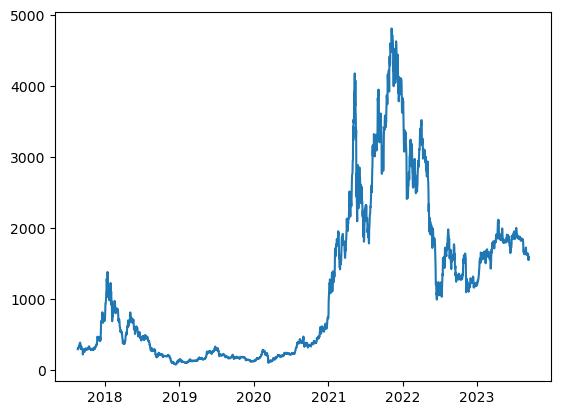

In [6]:
#plot historical eth price
plt.plot(close)

In [7]:
# build 1 week lookback for lstm training
def prepare_dataframe_for_lstm(data, n_steps):
    data = dc(data)
    
    for i in range(1, n_steps+1):
        data[f'Close(t-{i})'] = data['Close'].shift(i)
        
    data.dropna(inplace=True)
    
    return data

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2017-08-27,347.55,332.38,329.00,323.84,315.61,312.22,319.31,298.40
2017-08-28,346.68,347.55,332.38,329.00,323.84,315.61,312.22,319.31
2017-08-29,372.37,346.68,347.55,332.38,329.00,323.84,315.61,312.22
2017-08-30,383.03,372.37,346.68,347.55,332.38,329.00,323.84,315.61
2017-08-31,388.00,383.03,372.37,346.68,347.55,332.38,329.00,323.84
...,...,...,...,...,...,...,...,...
2023-09-08,1636.00,1647.90,1632.20,1634.00,1629.70,1635.80,1637.10,1628.60
2023-09-09,1635.30,1636.00,1647.90,1632.20,1634.00,1629.70,1635.80,1637.10
2023-09-10,1616.80,1635.30,1636.00,1647.90,1632.20,1634.00,1629.70,1635.80


In [8]:
#create array of dates for plotting from index. Must be shifted by 7 to match time series data, 
# since time series is 7 days and does not generate until the 7th day
# data starts on 9/13/11, but series don't start until 9/20
dates = data.index
dates = dates[7:]
dates.shape

(2198,)

In [9]:
#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()




shifted_df_as_np

array([[ 347.55,  332.38,  329.  , ...,  312.22,  319.31,  298.4 ],
       [ 346.68,  347.55,  332.38, ...,  315.61,  312.22,  319.31],
       [ 372.37,  346.68,  347.55, ...,  323.84,  315.61,  312.22],
       ...,
       [1616.8 , 1635.3 , 1636.  , ..., 1634.  , 1629.7 , 1635.8 ],
       [1551.7 , 1616.8 , 1635.3 , ..., 1632.2 , 1634.  , 1629.7 ],
       [1593.9 , 1551.7 , 1616.8 , ..., 1647.9 , 1632.2 , 1634.  ]])

In [10]:
shifted_df_as_np.shape

(2198, 8)

In [11]:
non_positive_indices = np.where(shifted_df_as_np <= 0)
print(non_positive_indices)


(array([], dtype=int64), array([], dtype=int64))


In [12]:
shifted_df_as_np_int = shifted_df_as_np.astype(int)
log_transformed_data = np.log(shifted_df_as_np_int)

In [13]:
log_transformed_data

array([[5.84932478, 5.80513497, 5.79605775, ..., 5.74300319, 5.7651911 ,
        5.69709349],
       [5.84643878, 5.84932478, 5.80513497, ..., 5.75257264, 5.74300319,
        5.7651911 ],
       [5.91889385, 5.84643878, 5.84932478, ..., 5.77765232, 5.75257264,
        5.74300319],
       ...,
       [7.38770924, 7.39939808, 7.40000952, ..., 7.39878628, 7.39572161,
        7.39939808],
       [7.34665516, 7.38770924, 7.39939808, ..., 7.39756154, 7.39878628,
        7.39572161],
       [7.37337431, 7.34665516, 7.38770924, ..., 7.40671073, 7.39756154,
        7.39878628]])

In [14]:
log_transformed_data.shape

(2198, 8)

In [15]:
# check shapes
X1 = log_transformed_data[:, 1:]
y1 = log_transformed_data[:, 0]

X1.shape, y1.shape

((2198, 7), (2198,))

In [16]:
#flip order of windows

X1 = dc(np.flip(X1, axis=1))
X1

array([[5.69709349, 5.7651911 , 5.74300319, ..., 5.77765232, 5.79605775,
        5.80513497],
       [5.7651911 , 5.74300319, 5.75257264, ..., 5.79605775, 5.80513497,
        5.84932478],
       [5.74300319, 5.75257264, 5.77765232, ..., 5.80513497, 5.84932478,
        5.84643878],
       ...,
       [7.39939808, 7.39572161, 7.39878628, ..., 7.40671073, 7.40000952,
        7.39939808],
       [7.39572161, 7.39878628, 7.39756154, ..., 7.40000952, 7.39939808,
        7.38770924],
       [7.39878628, 7.39756154, 7.40671073, ..., 7.39939808, 7.38770924,
        7.34665516]])

In [17]:
dates_train1, X_train1, y_train1 = dates[:1596],X1[:1596], y1[:1596]
dates_val1, X_val1, y_val1 = dates[1596:1896], X1[1596:1896], y1[1596:1896]
dates_test1, X_test1, y_test1 = dates[1896:], X1[1896:], y1[1896:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((1596, 7), (1596,), (300, 7), (300,), (302, 7), (302,))

In [18]:
model = Sequential([layers.Input((7, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100)

2023-09-12 19:56:56.050973: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
50/50 [==============================] - 4s 20ms/step - loss: 24.6040 - mean_absolute_error: 4.6186 - val_loss: 5.4463 - val_mean_absolute_error: 2.3062
Epoch 2/100
50/50 [==============================] - 0s 8ms/step - loss: 1.3248 - mean_absolute_error: 0.9607 - val_loss: 2.4362 - val_mean_absolute_error: 1.5204
Epoch 3/100
50/50 [==============================] - 0s 7ms/step - loss: 1.1222 - mean_absolute_error: 0.8872 - val_loss: 1.7724 - val_mean_absolute_error: 1.2869
Epoch 4/100
50/50 [==============================] - 0s 8ms/step - loss: 0.8571 - mean_absolute_error: 0.7604 - val_loss: 0.8784 - val_mean_absolute_error: 0.9093
Epoch 5/100
50/50 [==============================] - 0s 8ms/step - loss: 0.0930 - mean_absolute_error: 0.2002 - val_loss: 0.0097 - val_mean_absolute_error: 0.0758
Epoch 6/100
50/50 [==============================] - 0s 8ms/step - loss: 0.0134 - mean_absolute_error: 0.0912 - val_loss: 0.0125 - val_mean_absolute_error: 0.0882
Epoch 7/100
50/50 [=

Epoch 51/100
50/50 [==============================] - 1s 12ms/step - loss: 0.0054 - mean_absolute_error: 0.0544 - val_loss: 0.0041 - val_mean_absolute_error: 0.0478
Epoch 52/100
50/50 [==============================] - 1s 13ms/step - loss: 0.0060 - mean_absolute_error: 0.0595 - val_loss: 0.0037 - val_mean_absolute_error: 0.0451
Epoch 53/100
50/50 [==============================] - 1s 13ms/step - loss: 0.0059 - mean_absolute_error: 0.0575 - val_loss: 0.0054 - val_mean_absolute_error: 0.0604
Epoch 54/100
50/50 [==============================] - 1s 12ms/step - loss: 0.0057 - mean_absolute_error: 0.0570 - val_loss: 0.0158 - val_mean_absolute_error: 0.1113
Epoch 55/100
50/50 [==============================] - 0s 10ms/step - loss: 0.0058 - mean_absolute_error: 0.0569 - val_loss: 0.0037 - val_mean_absolute_error: 0.0453
Epoch 56/100
50/50 [==============================] - 0s 9ms/step - loss: 0.0050 - mean_absolute_error: 0.0520 - val_loss: 0.0039 - val_mean_absolute_error: 0.0465
Epoch 57/10

50/50 [==============================] - 2s 4ms/step


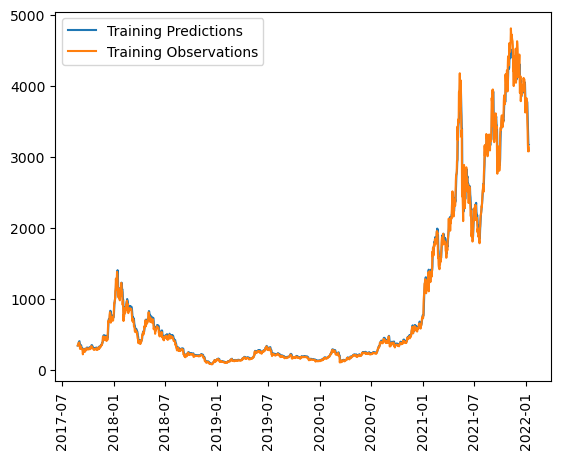

In [19]:
train_predictions = model.predict(X_train1).flatten()

plt.plot(dates_train1, np.exp(train_predictions))
plt.plot(dates_train1, np.exp(y_train1))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

10/10 [==============================] - 0s 4ms/step


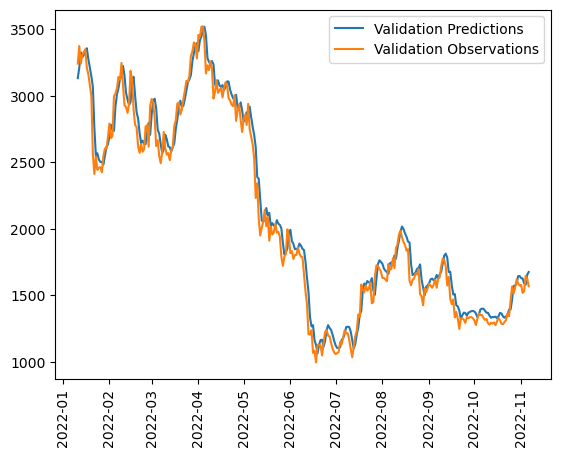

In [20]:
val_predictions = model.predict(X_val1).flatten()

plt.plot(dates_val1, np.exp(val_predictions))
plt.plot(dates_val1, np.exp(y_val1))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

10/10 [==============================] - 0s 5ms/step


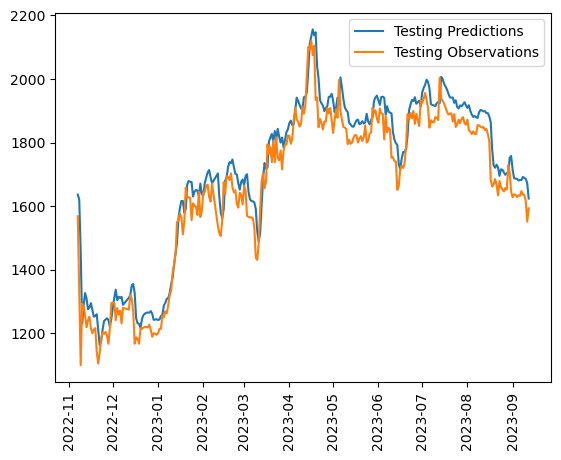

In [21]:
test_predictions = model.predict(X_test1).flatten()

plt.plot(dates_test1, np.exp(test_predictions))
plt.plot(dates_test1, np.exp(y_test1))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [22]:
#change timeframe

dates_train2, X_train2, y_train2 = dates[1000:1800],X1[1000:1800], y1[1000:1800]
dates_val2, X_val2, y_val2 = dates[1800:2000], X1[1800:2000], y1[1800:2000]
dates_test2, X_test2, y_test2 = dates[2000:], X1[2000:], y1[2000:]
dates_train2.shape, X_train2.shape, y_train2.shape, \
dates_val2.shape, X_val2.shape, y_val2.shape, \
dates_test2.shape, X_test2.shape, y_test2.shape

((800,), (800, 7), (800,), (200,), (200, 7), (200,), (198,), (198, 7), (198,))

In [23]:
model2 = Sequential([layers.Input((7, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model2.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model2.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=100)

Epoch 1/100
25/25 [==============================] - 9s 144ms/step - loss: 42.2002 - mean_absolute_error: 6.4008 - val_loss: 22.3574 - val_mean_absolute_error: 4.7265
Epoch 2/100
25/25 [==============================] - 0s 13ms/step - loss: 6.7841 - mean_absolute_error: 2.0932 - val_loss: 1.1507 - val_mean_absolute_error: 1.0642
Epoch 3/100
25/25 [==============================] - 0s 13ms/step - loss: 1.0505 - mean_absolute_error: 0.8615 - val_loss: 0.0363 - val_mean_absolute_error: 0.1506
Epoch 4/100
25/25 [==============================] - 0s 14ms/step - loss: 0.7797 - mean_absolute_error: 0.7442 - val_loss: 0.0181 - val_mean_absolute_error: 0.1195
Epoch 5/100
25/25 [==============================] - 0s 14ms/step - loss: 0.7432 - mean_absolute_error: 0.7376 - val_loss: 0.0178 - val_mean_absolute_error: 0.1178
Epoch 6/100
25/25 [==============================] - 0s 12ms/step - loss: 0.7044 - mean_absolute_error: 0.7252 - val_loss: 0.0186 - val_mean_absolute_error: 0.1149
Epoch 7/100
2

Epoch 51/100
25/25 [==============================] - 0s 14ms/step - loss: 0.0056 - mean_absolute_error: 0.0568 - val_loss: 0.0040 - val_mean_absolute_error: 0.0459
Epoch 52/100
25/25 [==============================] - 0s 12ms/step - loss: 0.0062 - mean_absolute_error: 0.0606 - val_loss: 0.0030 - val_mean_absolute_error: 0.0384
Epoch 53/100
25/25 [==============================] - 0s 14ms/step - loss: 0.0057 - mean_absolute_error: 0.0567 - val_loss: 0.0048 - val_mean_absolute_error: 0.0530
Epoch 54/100
25/25 [==============================] - 0s 19ms/step - loss: 0.0056 - mean_absolute_error: 0.0581 - val_loss: 0.0042 - val_mean_absolute_error: 0.0528
Epoch 55/100
25/25 [==============================] - 0s 12ms/step - loss: 0.0065 - mean_absolute_error: 0.0626 - val_loss: 0.0100 - val_mean_absolute_error: 0.0862
Epoch 56/100
25/25 [==============================] - 0s 12ms/step - loss: 0.0069 - mean_absolute_error: 0.0645 - val_loss: 0.0029 - val_mean_absolute_error: 0.0388
Epoch 57/1

25/25 [==============================] - 2s 5ms/step


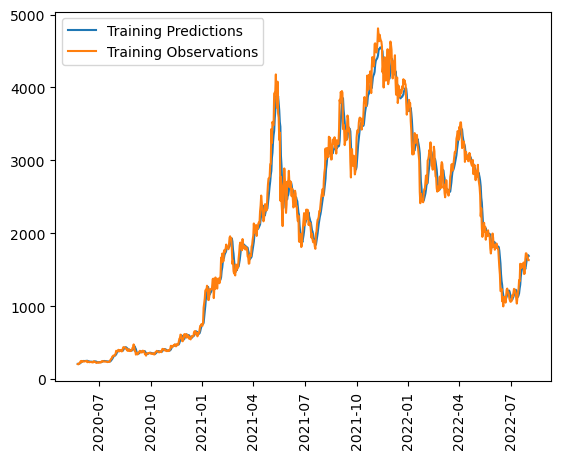

In [24]:
train_predictions2 = model2.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions2))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

7/7 [==============================] - 2s 6ms/step


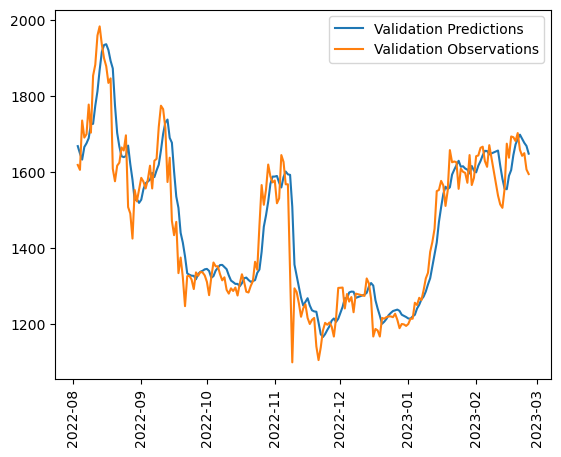

In [25]:
val_predictions2 = model2.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions2))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

7/7 [==============================] - 0s 5ms/step


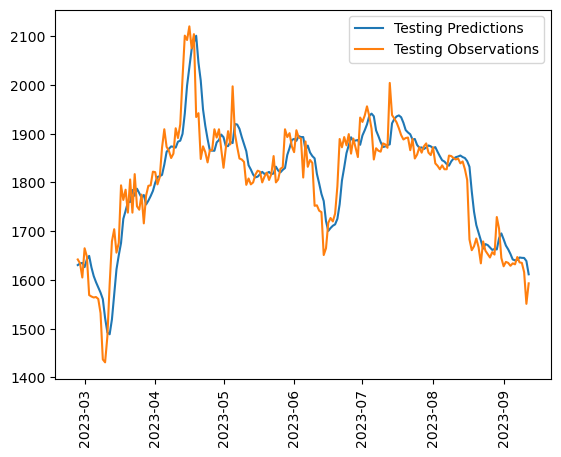

In [26]:
test_predictions2 = model2.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions2))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [ ]:
model3 = Sequential([layers.Input((7, 1)),
                    layers.LSTM(64),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(1)])

model3.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model3.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=200)

Epoch 1/200
25/25 [==============================] - 3s 35ms/step - loss: 24.0268 - mean_absolute_error: 4.3620 - val_loss: 0.5609 - val_mean_absolute_error: 0.7376
Epoch 2/200
25/25 [==============================] - 0s 9ms/step - loss: 1.6753 - mean_absolute_error: 1.0809 - val_loss: 0.2756 - val_mean_absolute_error: 0.5089
Epoch 3/200
25/25 [==============================] - 0s 9ms/step - loss: 0.7085 - mean_absolute_error: 0.6972 - val_loss: 0.0301 - val_mean_absolute_error: 0.1369
Epoch 4/200
25/25 [==============================] - 0s 9ms/step - loss: 0.5965 - mean_absolute_error: 0.6682 - val_loss: 0.0145 - val_mean_absolute_error: 0.1042
Epoch 5/200
25/25 [==============================] - 0s 9ms/step - loss: 0.4456 - mean_absolute_error: 0.5727 - val_loss: 0.0562 - val_mean_absolute_error: 0.2171
Epoch 6/200
25/25 [==============================] - 0s 10ms/step - loss: 0.2056 - mean_absolute_error: 0.3749 - val_loss: 0.0041 - val_mean_absolute_error: 0.0509
Epoch 7/200
25/25 [

Epoch 51/200
25/25 [==============================] - 0s 8ms/step - loss: 0.0058 - mean_absolute_error: 0.0590 - val_loss: 0.0027 - val_mean_absolute_error: 0.0352
Epoch 52/200
25/25 [==============================] - 0s 8ms/step - loss: 0.0050 - mean_absolute_error: 0.0540 - val_loss: 0.0026 - val_mean_absolute_error: 0.0355
Epoch 53/200
25/25 [==============================] - 0s 9ms/step - loss: 0.0056 - mean_absolute_error: 0.0569 - val_loss: 0.0044 - val_mean_absolute_error: 0.0501
Epoch 54/200
25/25 [==============================] - 0s 8ms/step - loss: 0.0053 - mean_absolute_error: 0.0564 - val_loss: 0.0026 - val_mean_absolute_error: 0.0348
Epoch 55/200
25/25 [==============================] - 0s 9ms/step - loss: 0.0058 - mean_absolute_error: 0.0585 - val_loss: 0.0067 - val_mean_absolute_error: 0.0663
Epoch 56/200
25/25 [==============================] - 0s 8ms/step - loss: 0.0052 - mean_absolute_error: 0.0555 - val_loss: 0.0084 - val_mean_absolute_error: 0.0775
Epoch 57/200
25/

Epoch 101/200
25/25 [==============================] - 0s 8ms/step - loss: 0.0047 - mean_absolute_error: 0.0532 - val_loss: 0.0025 - val_mean_absolute_error: 0.0374
Epoch 102/200
25/25 [==============================] - 0s 8ms/step - loss: 0.0040 - mean_absolute_error: 0.0477 - val_loss: 0.0028 - val_mean_absolute_error: 0.0376
Epoch 103/200
25/25 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_absolute_error: 0.0477 - val_loss: 0.0029 - val_mean_absolute_error: 0.0378
Epoch 104/200
25/25 [==============================] - 0s 9ms/step - loss: 0.0042 - mean_absolute_error: 0.0497 - val_loss: 0.0023 - val_mean_absolute_error: 0.0318
Epoch 105/200
25/25 [==============================] - 0s 7ms/step - loss: 0.0052 - mean_absolute_error: 0.0543 - val_loss: 0.0027 - val_mean_absolute_error: 0.0362
Epoch 106/200
25/25 [==============================] - 0s 8ms/step - loss: 0.0050 - mean_absolute_error: 0.0544 - val_loss: 0.0022 - val_mean_absolute_error: 0.0327
Epoch 107/

25/25 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_absolute_error: 0.0468 - val_loss: 0.0023 - val_mean_absolute_error: 0.0337
Epoch 151/200
25/25 [==============================] - 0s 7ms/step - loss: 0.0039 - mean_absolute_error: 0.0482 - val_loss: 0.0031 - val_mean_absolute_error: 0.0414
Epoch 152/200
25/25 [==============================] - 0s 7ms/step - loss: 0.0034 - mean_absolute_error: 0.0440 - val_loss: 0.0018 - val_mean_absolute_error: 0.0286
Epoch 153/200
25/25 [==============================] - 0s 8ms/step - loss: 0.0033 - mean_absolute_error: 0.0433 - val_loss: 0.0022 - val_mean_absolute_error: 0.0326
Epoch 154/200
25/25 [==============================] - 0s 7ms/step - loss: 0.0038 - mean_absolute_error: 0.0475 - val_loss: 0.0024 - val_mean_absolute_error: 0.0373
Epoch 155/200
25/25 [==============================] - 0s 7ms/step - loss: 0.0037 - mean_absolute_error: 0.0453 - val_loss: 0.0019 - val_mean_absolute_error: 0.0307
Epoch 156/200
25/25 [==

25/25 [==============================] - 2s 9ms/step


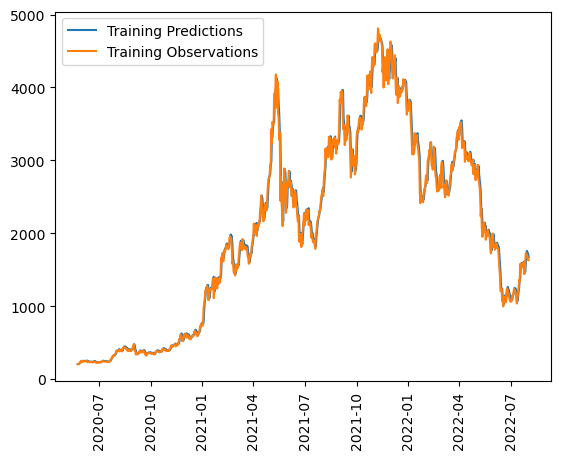

In [28]:
train_predictions3 = model3.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions3))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

7/7 [==============================] - 1s 5ms/step


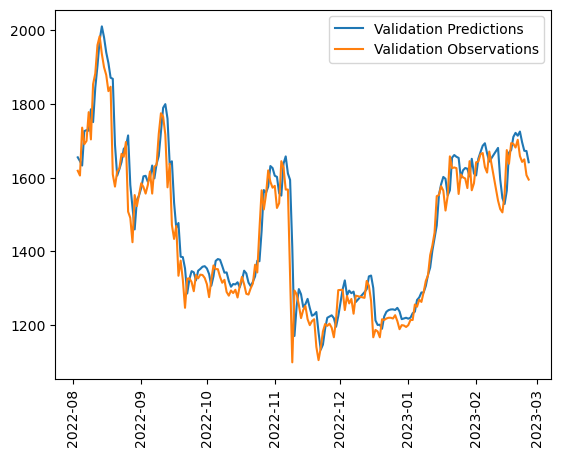

In [29]:
val_predictions3 = model3.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions3))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

7/7 [==============================] - 0s 5ms/step


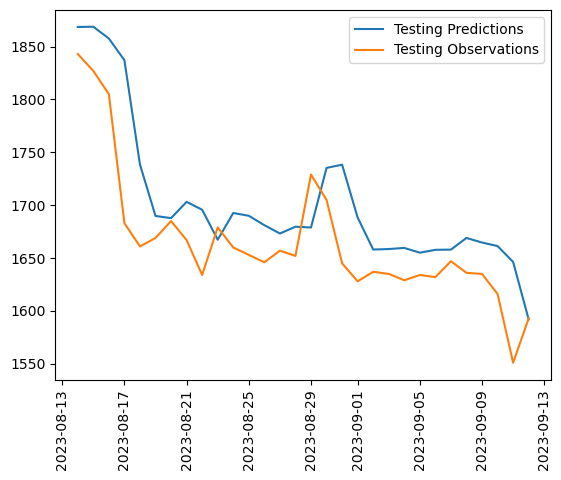

In [30]:
test_predictions3 = model3.predict(X_test2).flatten()

plt.plot(dates_test2[-30:], np.exp(test_predictions3[-30:]))
plt.plot(dates_test2[-30:],np.exp(y_test2[-30:]))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [31]:
# Initialize an array to store predictions
predictions = []
predicted_dates = []
prediction_range = 7

#create list of numbers to add to date based on date range
date_range = list(range(1, prediction_range +1))

# Use the last n_steps data points from the training set to make predictions
current_batch = X_test2[-1].reshape((1, 7, 1))
initial_date = dates_test2[-1]

for i in range(prediction_range):  # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model3.predict(current_batch)[0,0]
    
    # Append the prediction to the list of predictions
    predictions.append(current_pred)
        
    # Shift the current batch one step forward
    current_batch = np.roll(current_batch, shift=-1, axis=1)
    current_batch[0, -1, 0] = current_pred
    

    
for day in date_range:
    new_date = initial_date + dt.timedelta(days=day)
    predicted_dates.append(new_date
                          )
# Assuming 'predictions' contains your 7-day forecast
print(predictions)

for date in predicted_dates:
    print(date)

1/1 [==============================] - 0s 43ms/step
[7.3727317, 7.3809524, 7.393184, 7.405716, 7.4185367, 7.4316497, 7.444938]
2023-09-13
2023-09-14
2023-09-15
2023-09-16
2023-09-17
2023-09-18
2023-09-19


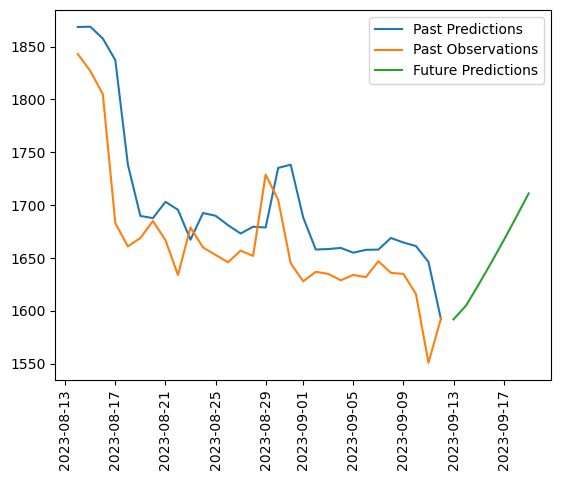

In [32]:
plt.plot(dates_test2[-30:], np.exp(test_predictions3[-30:]))
plt.plot(dates_test2[-30:],np.exp(y_test2[-30:]))
plt.plot(predicted_dates, np.exp(predictions))
plt.xticks(rotation=90)
plt.legend(['Past Predictions', 'Past Observations','Future Predictions'])

In [33]:
# Export our model to HDF5 file
model3.save("H5_Files/ETH_30_day_lookback.h5")